In this peroject, you will create a deep learning model that detects the TNt tubes formed in between cells. Below is a berief decsripton of what TNTs are:

"Tunneling nanotubes (TNTs) are elongated structures extending from and connecting cancer cell membranes. They permit the exchange of molecules, vesicles, and mitochondria, as well as genetic and metabolic signals that promote carcinogenesis. Given that they permit intercellular trafficking and communication, TNTs may serve as an important imaging biomarker of cancer cell response vs. resistance to therapy. On fluorescence imaging of cancer cell cultures, TNTs appear to be no thicker than 1 µm and vary in length from 10 to 100+ µm. TNTs can be spotted by a trained eye, but using human experts to obtain an accurate count and location of TNTs is a time-intensive process. A precise quantitative analysis of TNTs could aid in the objective assessment of cancer response to various therapeutic interventions."

In this project, the original images were created by taking a grid of 5 × 5 tiled images, each measuring 1388 × 1040 pixels, and then stitching them together. This process resulted in shadows along the stitched edges, which significantly degraded the model performance at later stages. You may start from removing these shadows. To remove those shadows, you may use BaSiC, an image correction method for background and shading correction for image sequences, available as a Fiji/ImageJ. You may consider other packages/lobraries for this purpose. You may also consider using different filters. You may check the following link: https://www.youtube.com/watch?v=xCHbcVUCYBI. You may find very useful short videos in that channel for image processing.

After preprocessing, you may want to divide the original image into smaller pieces. The original image in the training dataset was stitched together resulting in an image - size of 6283 × 4687 pixels. You can scan the images  with a sliding window of 512 × 512 pixels with a stride of 10 pixels, extracting patches containing the TNT regions using a bounding box. You may write a function that takes the window size as input. You may later create smaller images from 512x512 images using the same function.

Once you form training and test datasets from smaller images, you may simply train a VGG model. You may try different models. you goal is to find the images that contain TNTs. You may create multiple models that are trained with images with different sizes. 

# Image Preprocessing

This is the image with labels

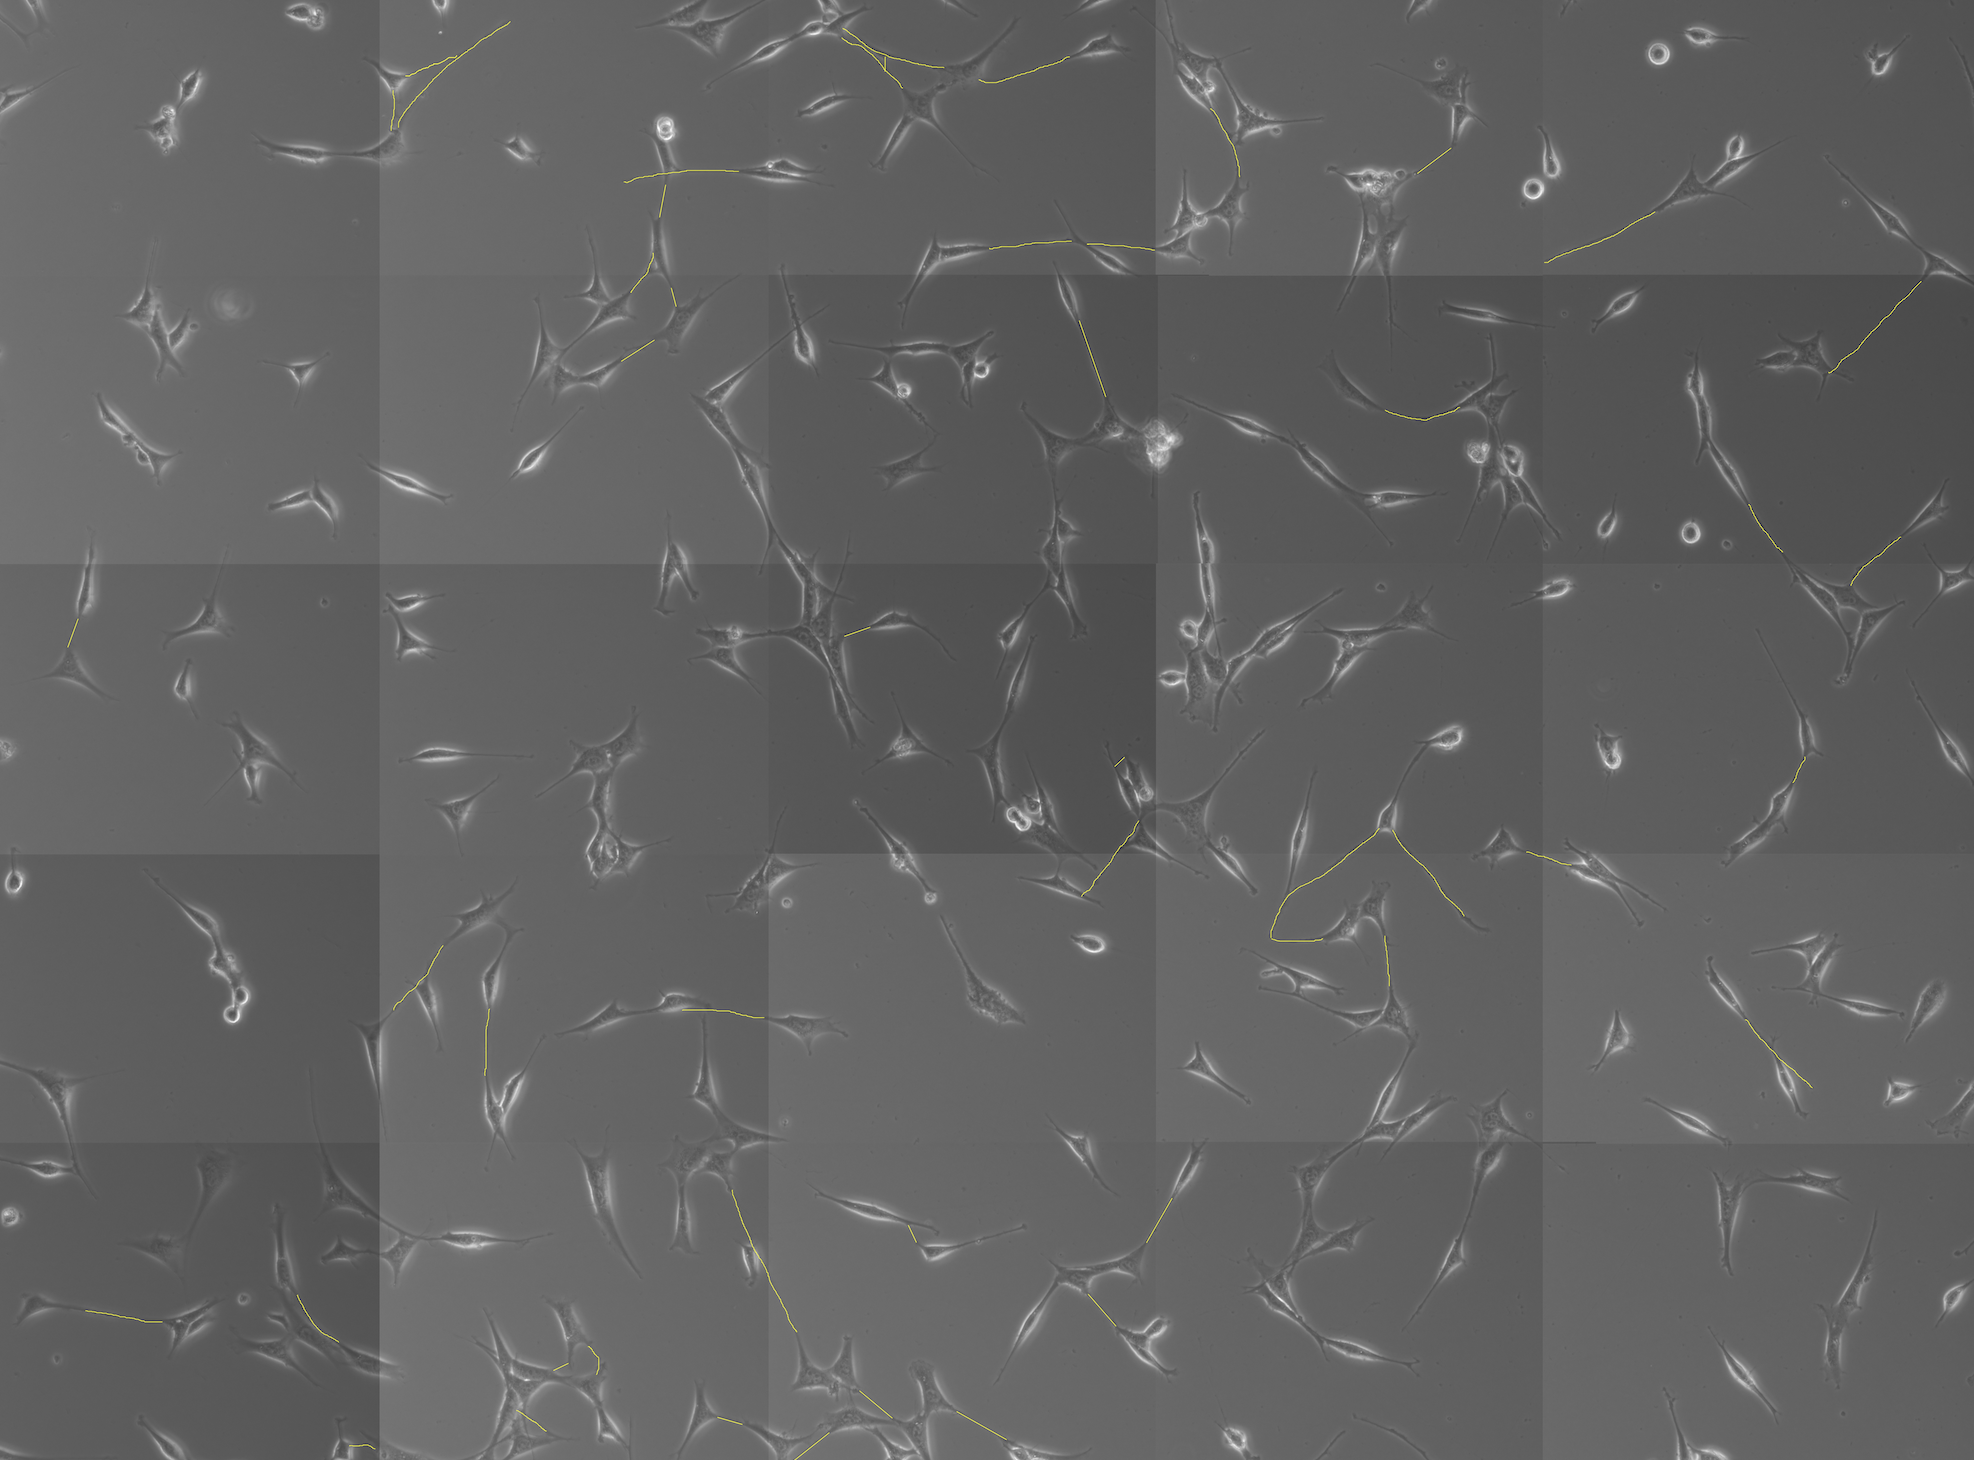

This is the same image without labels.

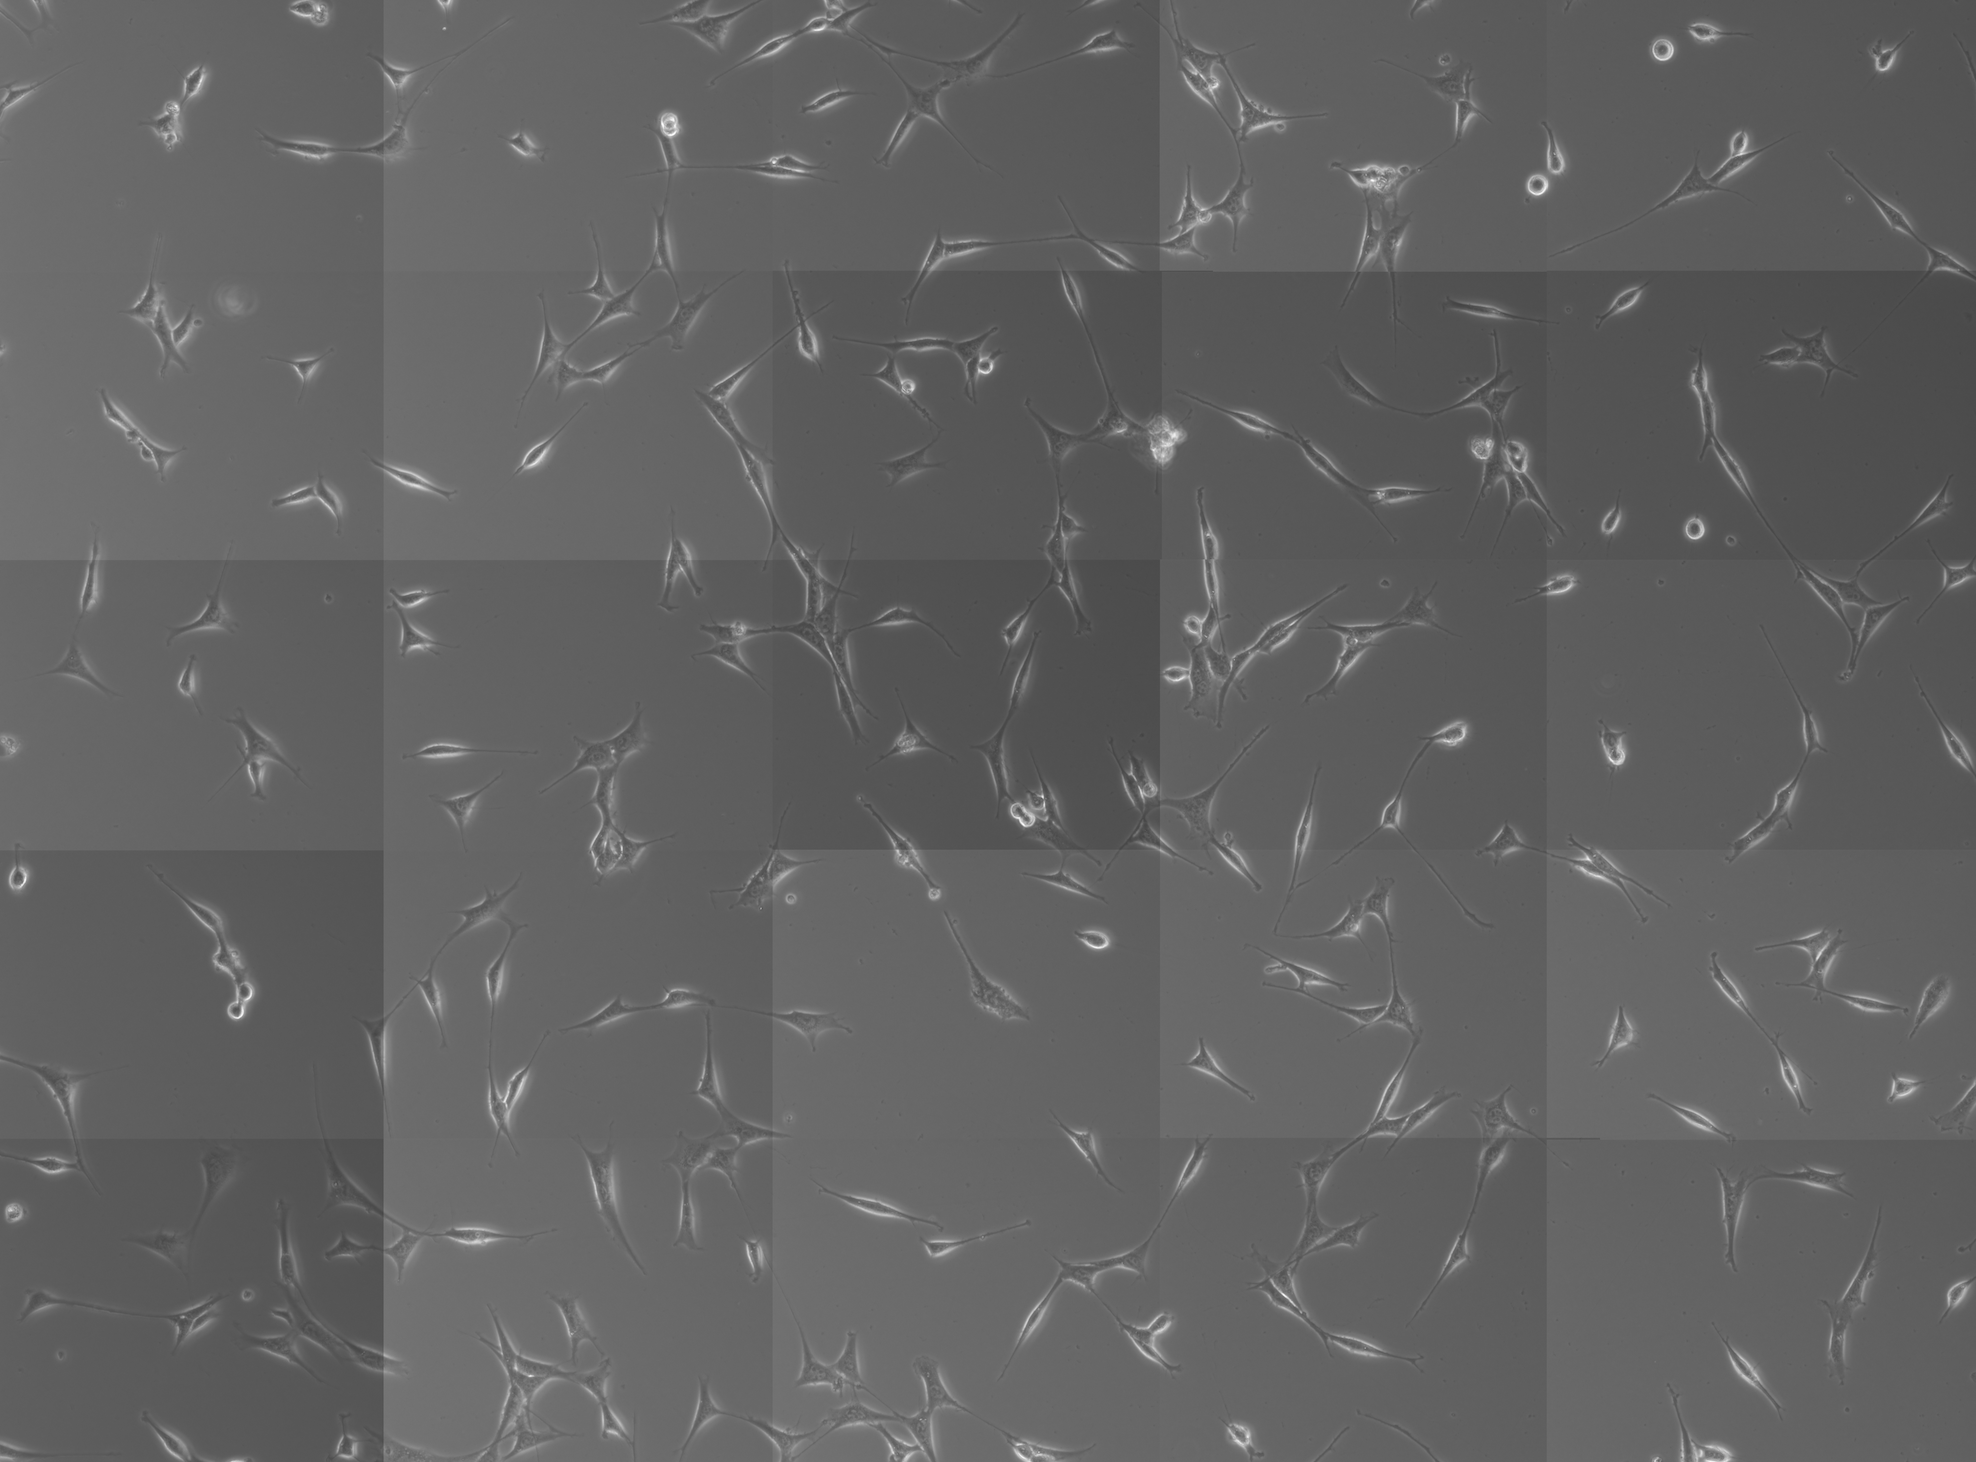

- Create folders to save the images that are created by splitting the main image into smaller pieces


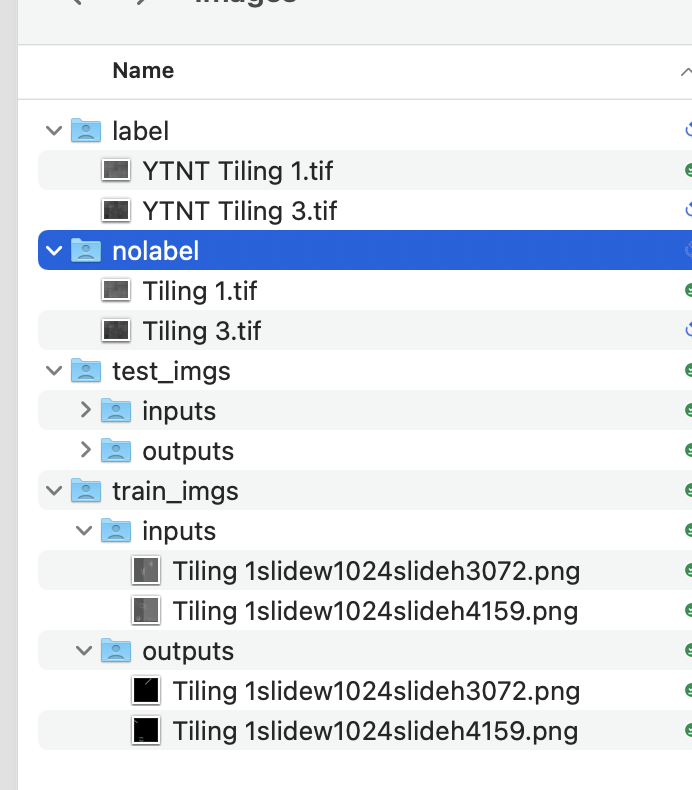

- Create smaller pieces from the main image by moving a window along the image. Mark the pieces with TNTs as 1 and all others as 0. This will give you the labeled images for your classification model.

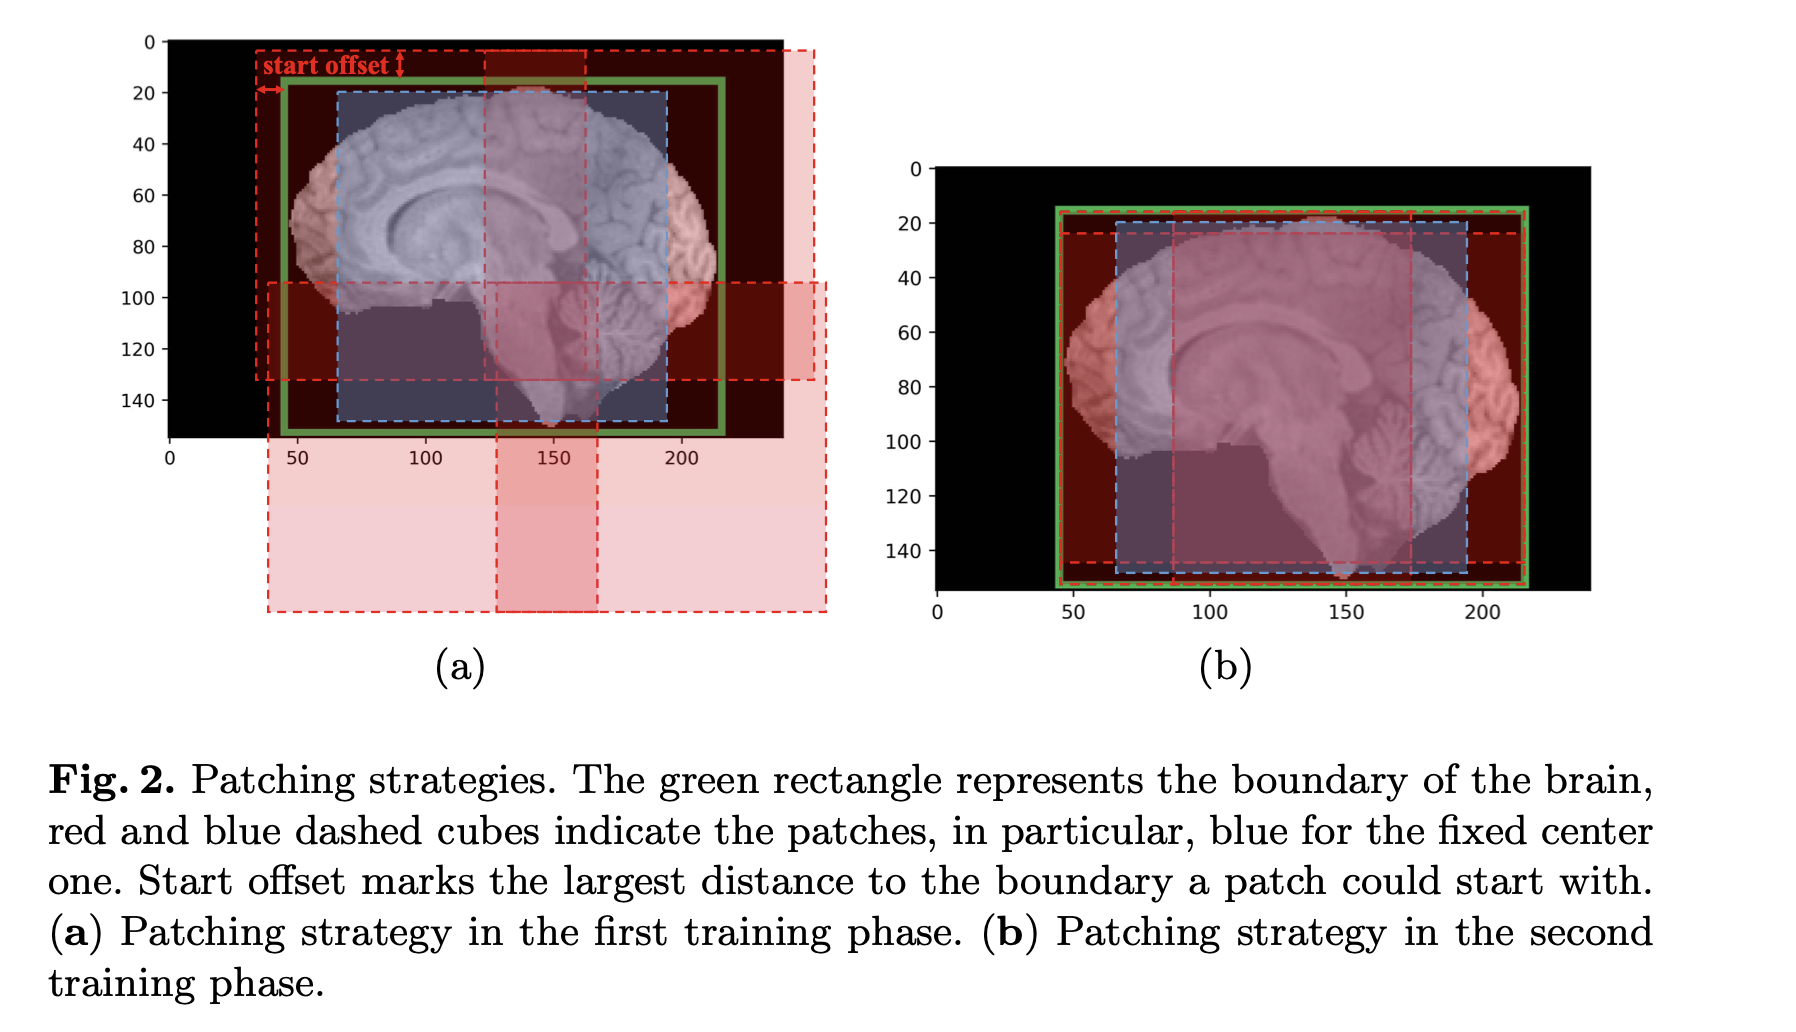

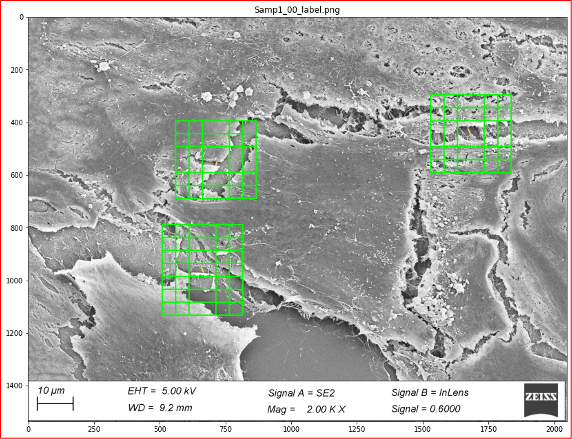

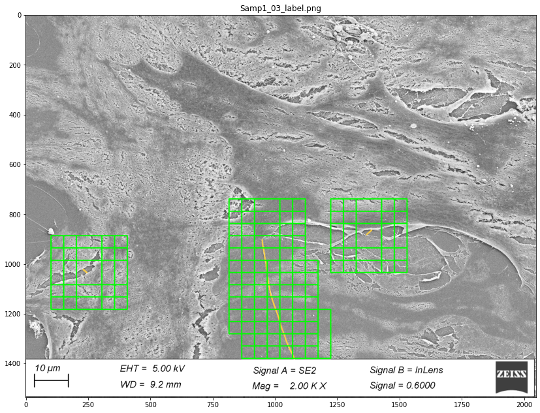

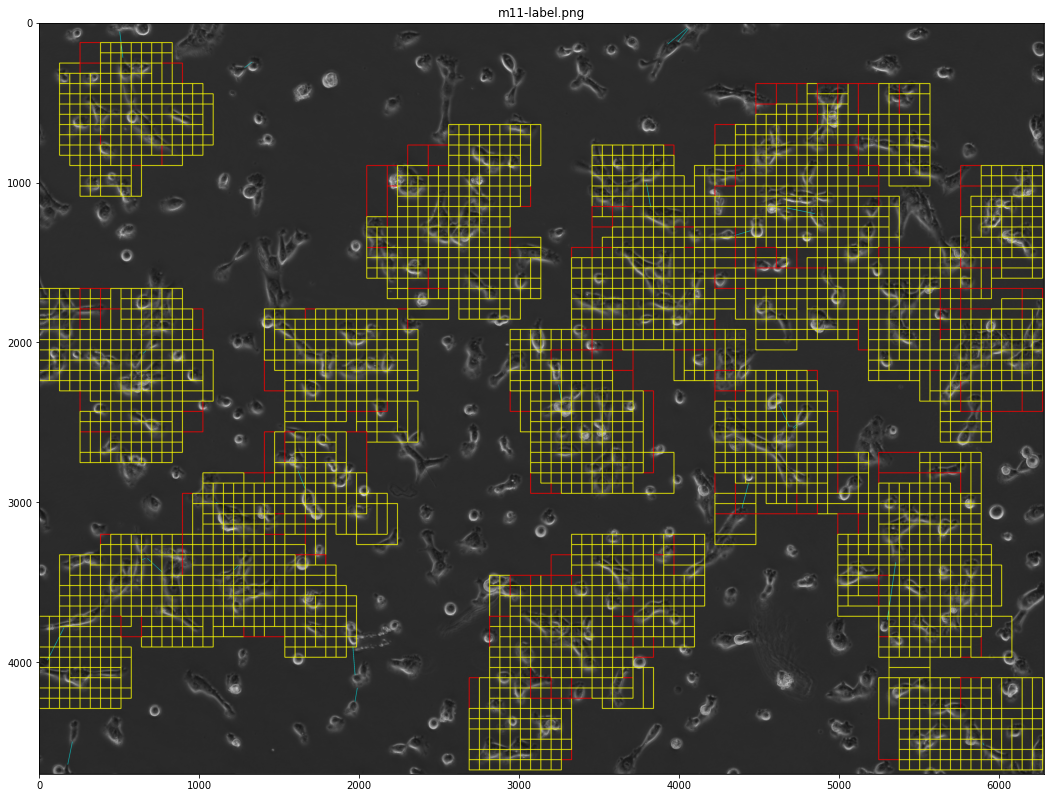


# classification model training



- Use cv2.threshold and cv2.dilate to create image masks

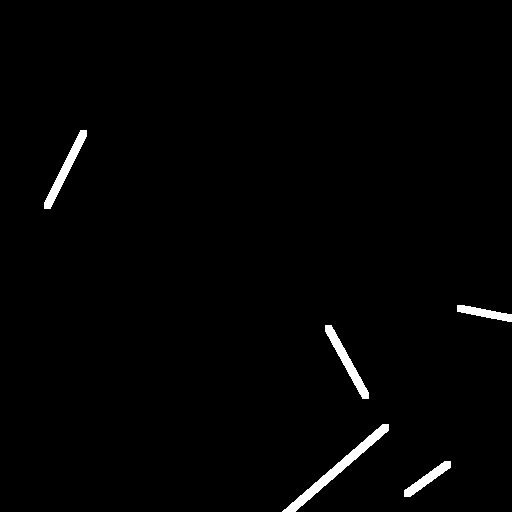

- Use transfer learning to create a classification model for images with and without TNTs
- You can start from and use VGG16
- Your goal is to run as many as models as the types of images you created in the preprocessing step, that is, if you created images of size 512 and 250 pixels, then you will have two models for each image size.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
# from skimage import io, filters
from scipy import ndimage
import sys

In [2]:
DATADIR = r'D:\\Study 2018 and later\\Mignimind Bootcamp\\Code\\Temp Data for P6' 
CATEGORIES = [0,1]
plt.rcParams['figure.figsize'] = [15, 15]

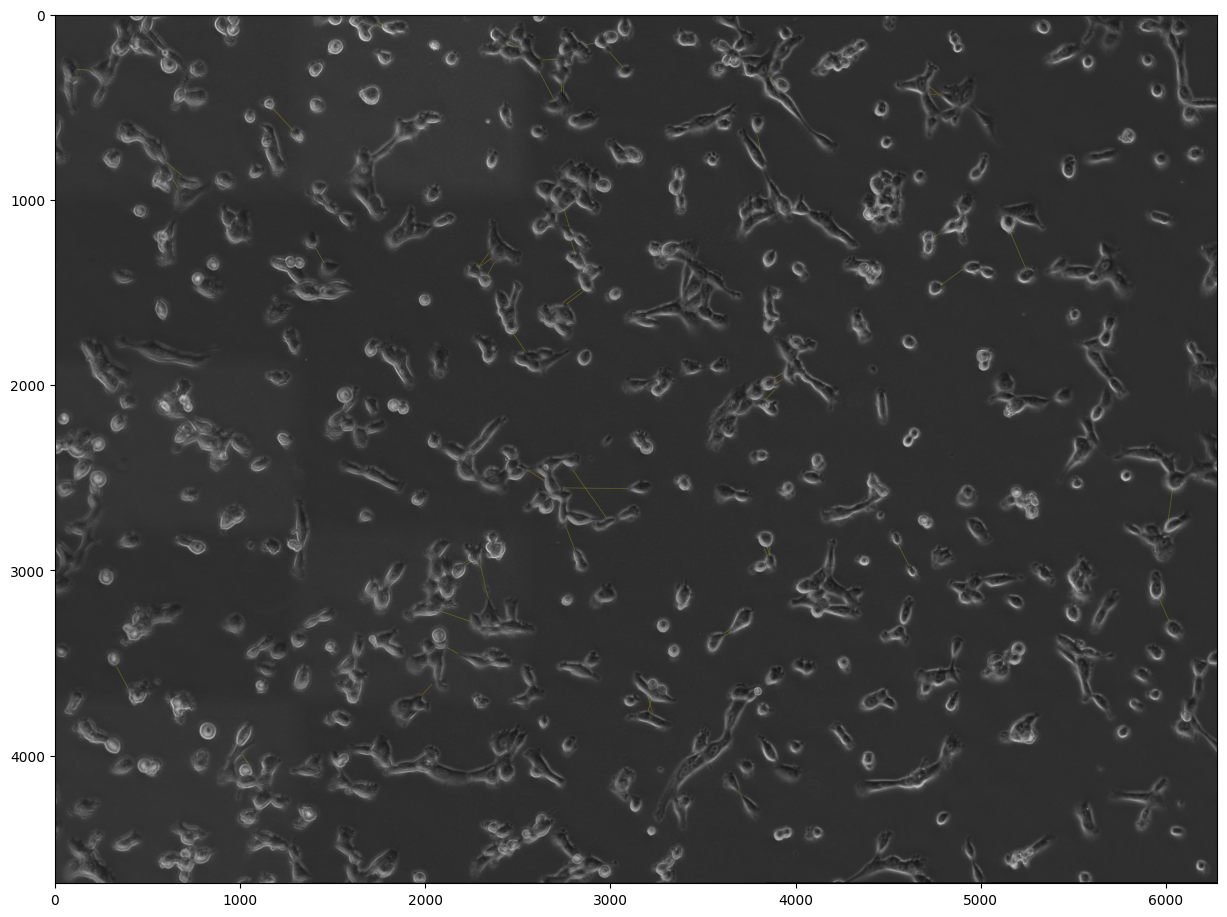

In [3]:
img_array = cv2.imread(r'..\\TNT Project\\m05-label.jpg')
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

* To odevelop correct function for image generation I will play with parameters of: 
1. Parameters of our mask for identifying yellow TNTs in function cv2.inRange().
2. cv2.treshhold() - to recreate lines of the TNTs.
3. cv2.dilate() - to make the lines thicker and more visible.

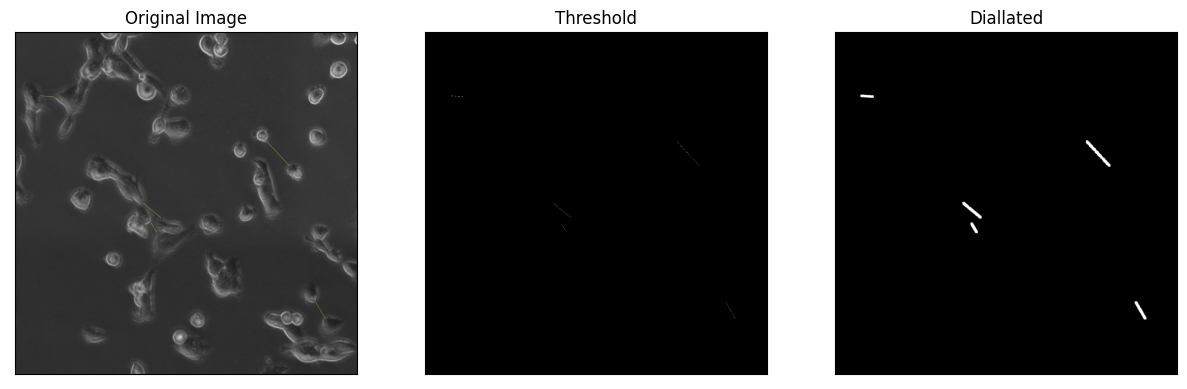

In [4]:
# cut smaller image of size 1600x1600 beginning at (0,0)
img_rgb_1600 = img_rgb[0:1600, 0:1600]
# check if we have yellow pixels in the image
yellow_low = np.array([120, 120, 0])
yellow_high = np.array([255, 255, 100])
mask = cv2.inRange(img_rgb_1600, yellow_low, yellow_high)
_, mask_th = cv2.threshold(mask, 30, 255,cv2.THRESH_BINARY )

mask_th_diallated = cv2.dilate(mask_th, np.ones((3,3), np.uint8), iterations=5)
images = [img_rgb_1600, mask_th, mask_th_diallated]
titles = ['Original Image','Threshold', 'Diallated']
for i in range(3):
    plt.subplot(1, 3, i+1), plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

* Now when we checked the functionway to process pictures and can clearly see the lines of TNTs, we can start to create functions for image generation.

In [5]:
def emphasize_TNT(img):
    yellow_low = np.array([120, 120, 0])
    yellow_high = np.array([255, 255, 100])
    mask = cv2.inRange(img, yellow_low, yellow_high)
    _, mask_th = cv2.threshold(mask, 30, 255,cv2.THRESH_BINARY )
    mask_th_diallated = cv2.dilate(mask_th, np.ones((3,3), np.uint8), iterations=5)
    return mask_th_diallated

In [6]:
# create function to cut image into pieces
def cut_image(img, piece_size, shift):
    x = 0
    y = 0
    pieces = []
    while y + piece_size < img.shape[0]:
        while x + piece_size < img.shape[1]:
            pieces.append(img[y:y+piece_size, x:x+piece_size])
            x += shift
        x = 0
        y += shift
    return pieces

In [7]:
images_1600 = cut_image(img_rgb, 1600, 50)

In [8]:
tnt_1600 = []
for img in images_1600:
    emp_img = emphasize_TNT(img)
    tnt_1600.append(emp_img)

In [9]:
len (tnt_1600)

5828

* Now we will develop function to classify images in rule based way with and without TNTs. To be able to create training labeled set of pictures.
1. If no TNT in a picture - then label it as 0.
2. If TNT in the edge of the picture - then label it as 0.
3. If TNT not on the edge, but fully visible - then label it as 1. 
4. If some TNTs on the edge and some not - then label it as 2. 

* It is quite hard to manually find the case N3 from above, so I will picture only cases 1,2,4.

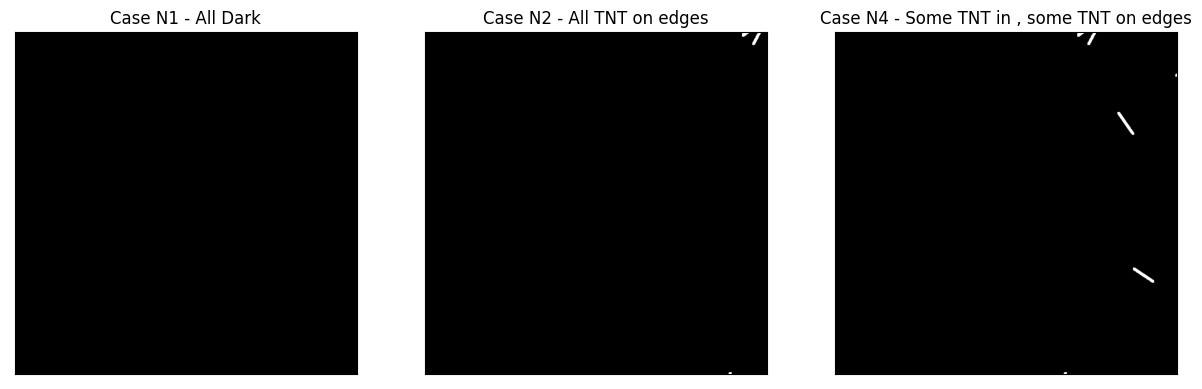

In [10]:
images_1600_to_plot = [tnt_1600[2550], tnt_1600[2554], tnt_1600[2561]]
images_1600_to_plot_titles = ['Case N1 - All Dark', 'Case N2 - All TNT on edges', 'Case N4 - Some TNT in , some TNT on edges']
for i in range(3):
    plt.subplot(1, 3, i+1), plt.imshow(images_1600_to_plot[i], 'gray')
    plt.title(images_1600_to_plot_titles[i])
    plt.xticks([]), plt.yticks([])

* Frame of 150 pix is necessary for the system to be able to see cells attached to TNT, not only TNT itself. So 150 pixels will give system better view of the picture and potentially will help to classify it better.

In [11]:
def check_tnt(img, frame_size):
    img_center = img[frame_size:-frame_size, frame_size:-frame_size]
    img_inside_center_1pix = img[frame_size+1:-frame_size-1, frame_size+1:-frame_size-1]

    # get sum of teh whole image
    img_sum = np.sum(img)
    # get sum of pixels outside of the center minus summs of corners because we have 4 corners
    img_frame_sum = np.sum(img[0:frame_size, :]) + np.sum(img[-frame_size:, :]) + np.sum(img[:, 0:frame_size]) + np.sum(img[:, -frame_size:]) \
    - np.sum(img[0:frame_size, 0:frame_size]) - np.sum(img[0:frame_size, -frame_size:]) - np.sum(img[-frame_size:, 0:frame_size]) - np.sum(img[-frame_size:, -frame_size:])

    # get sum of pixels inside the center
    img_center_sum = np.sum(img_center)
    # get sum of pixels inside the center 1 pixel
    img_inside_center_1pix_sum = np.sum(img_inside_center_1pix)
    # Calculate sum of 1 pix wide border inside the center
    img_border_sum = np.int64(img_sum) - np.int64(img_frame_sum) - np.int64(img_inside_center_1pix_sum)

    # -------------------------- For Debugging  BEGINS--------------------------
    # print (img_sum/255,'  - img_sum number of white pixels')
    # print(img_center_sum/255,' - img_center_sum number of white pixels ')
    # print(img_frame_sum/255,' - img_frame_sum number of white pixels ')
    # print(img_inside_center_1pix_sum/255,' - img_inside_center_1pix_sum number of white pixels ')
    # print(img_border_sum/255,' - img_border_sum number of white pixels ')

    # images_to_show = [img, img_center]
    # titles_to_show = ['Original Image', 'Center']
    # for i in range(2):
    #     plt.subplot(1, 2, i+1), plt.imshow(images_to_show[i], 'gray')
    #     plt.title(titles_to_show[i])
    #     plt.xticks([]), plt.yticks([])
    # -------------------------- For Debugging  END --------------------------
    if ((img_sum == 0) or                                                           # case 1
            (img_frame_sum > 0 and img_center_sum == 0 and img_border_sum == 0) or  # case 2
            (img_frame_sum == 0 and img_center_sum == 0 and img_border_sum > 0) or  # case 4
            (img_frame_sum > 0 and img_center_sum == 0 and img_border_sum > 0)):    # case 6
        return 0
    elif ((img_frame_sum == 0 and img_center_sum > 0 and img_border_sum == 0) or    # case 3
          (img_frame_sum == 0 and img_center_sum > 0 and img_border_sum > 0)):      # case 5
        return 1
    else:
        return 2 # case 6 and 7
    

In [12]:
monarch = cv2.imread(r'..\\TNT Project\Test-Monarch.jpg', cv2.IMREAD_GRAYSCALE)
print(monarch.shape)

(632, 800)


In [13]:
# quick tests
check_tnt(tnt_1600[2561],150)

2

* Now we try different sizes of cutting main image and see how many of each class we have in each size.
#### We have : 
1. function to cut images into smaller pieces - cut_image()
2. function to create masks for images with emphasized TNTs - emphasize_TNT()
3. function to label images with TNTs - check_tnt()

4. Different sizes of images
5. Differnt sizes of shifts

We need to create a table with different sizes of images starting from 270x270 to 1600-1600 and shift of 50/1600=0.031 pixels. Where we go down from 1600x0.8 in size to get to 270 pixels approximatelly.
The outcomig DF will have  columns: size,shift, number of images with label 0, number of images with label 1, number of images with label 2. I hope to be able to choose best size of images and shift for image generation. We can also go back to this and get some different shifts and sizes to see how the model will perform.

In [14]:
def get_sizes(max_size, stop_size, step):
    size = np.array(max_size)
    sizes = [size]
    while size[0] > stop_size:
        size = size*step
        sizes.append(size)

    sizes = [size.astype(int) for size in sizes]
    return sizes

sizes_shifts = get_sizes((1600,50), 270, 0.8)
sizes = [size[0] for size in sizes_shifts]
shifts = [size[1] for size in sizes_shifts]

size_shift_dict = dict(zip(sizes, shifts))
print(size_shift_dict)

{1600: 50, 1280: 40, 1024: 32, 819: 25, 655: 20, 524: 16, 419: 13, 335: 10, 268: 8}


* cut_image(img, piece_size, shift) # returns list of images  
* emphasize_TNT(img)                # returns image  
* check_tnt(img, frame_size)        # returns 0, 1 or 2  

In [18]:
df = pd.DataFrame(columns=['Size', 'Shift', 'Number of label 0', 'Number of label 1', 'Number of label 2'])

for size in size_shift_dict:
    pieces = cut_image(img_rgb, size, size_shift_dict[size])
    print('Size: ', size)
    print('Number of pieces: ', len(pieces))
    label_0 = 0
    label_1 = 0
    label_2 = 0
    for i,piece in enumerate(pieces):
        emp_img = emphasize_TNT(piece)
        tnt = check_tnt(emp_img, 150)

        if tnt == 0:
            label_0 += 1
        elif tnt == 1:
            label_1 += 1
        else:
            label_2 += 1
        
        if i%1000 == 0:
            print(i, 'pieces done of ', len(pieces), ' of size ', size)   
             
    df_temp = pd.DataFrame([[size, size_shift_dict[size], label_0, label_1, label_2]], columns=['Size', 'Shift', 'Number of label 0', 'Number of label 1', 'Number of label 2'])
    df = pd.concat([df, df_temp], ignore_index=True)
    print(df)

Size:  1600
Number of pieces:  5828
0 pieces done of  5828  of size  1600
1000 pieces done of  5828  of size  1600
2000 pieces done of  5828  of size  1600
3000 pieces done of  5828  of size  1600
4000 pieces done of  5828  of size  1600
5000 pieces done of  5828  of size  1600
   Size Shift Number of label 0 Number of label 1 Number of label 2
0  1600    50               513               934              4381
Size:  1280
Number of pieces:  10750
0 pieces done of  10750  of size  1280
1000 pieces done of  10750  of size  1280
2000 pieces done of  10750  of size  1280
3000 pieces done of  10750  of size  1280
4000 pieces done of  10750  of size  1280
5000 pieces done of  10750  of size  1280
6000 pieces done of  10750  of size  1280
7000 pieces done of  10750  of size  1280
8000 pieces done of  10750  of size  1280
9000 pieces done of  10750  of size  1280
10000 pieces done of  10750  of size  1280
   Size Shift Number of label 0 Number of label 1 Number of label 2
0  1600    50       

In [20]:
# pickle the dataframe
df.to_pickle(r'..\\TNT Project\\df_sizez_labels.pkl')
df

Size Shift Number of label 0 Number of label 1 Number of label 2
0  1600    50               513               934              4381
1  1280    40              2447              1434              6869
2  1024    32              7982              2631              8362
3   819    25             21376              3043              9526
4   655    20             44441              2516             10007
5   524    16             83084              1458              9418
6   419    13            140814               227              7338
7   335    10            255969                 1              3450
8   268     8            415856                 0                 0